### 1) Загрузите данные ex4data1.mat из файла.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = '/home/ataleckij/Projects/university/mo/Data/Lab 4/'

In [4]:
files_names = os.listdir(DATA_PATH)
print(files_names)
files_paths = [os.path.join(DATA_PATH, name) for name in files_names]

['ex4data1.mat', 'ex4weights.mat']


In [5]:
from scipy.io import loadmat

data = loadmat(files_paths[0])
weights = loadmat(files_paths[1])

features, labels = data['X'], data['y'].flatten()
print(features.shape, labels.shape)

(5000, 400) (5000,)


### 2) Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?

In [6]:
t1, t2 = weights['Theta1'], weights['Theta2']
print(t1.shape, t2.shape)

w1, b1 = t1[:, 1:], t1[:, [0]]
w2, b2 = t2[:, 1:], t2[:, [0]]

(25, 401) (10, 26)


### 3) Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации. 
### 8) Реализуйте функцию вычисления производной для функции активации.
### 9) Инициализируйте веса небольшими случайными числами.
### 10) Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

In [7]:
import numpy as np
import random

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [289]:
class Network:
    def __init__(self, sizes, output=True, random_state=None):
        """
        Список ``sizes`` содержит количество нейронов в соответствующих слоях
        нейронной сети. Смещения и веса для нейронных сетей
        инициализируются случайными значениями, подчиняющимися стандартному нормальному
        распределению. Первый слой подразумевается слоем, принимающим входные данные, 
        поэтому к нему не добавляется смещение
        """

        if random_state is not None:
            random = np.random.RandomState(random_state)
        else:
            random = np.random
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [random.randn(y, 1) for y in sizes[1:]]
        self.weights = [random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.output = output

    def feedforward(self, a, layer_i=None):
        """
        Вычислить и вернуть выходную активацию нейронной сети
        при получении ``a`` на входе
        """
        for layer_i_, (b, w) in enumerate(zip(self.biases, self.weights)):
            a = sigmoid(np.dot(w, a)+b.T[0])
            if layer_i is not None and layer_i_ == layer_i:
                break
        return a
    
    def predict(self, features):
        return np.asarray([self.feedforward(example_features) 
                           for example_features in features])
    
    def predict_classes(self, features):
        prediction_onehot = self.predict(features)
        return np.argmax(prediction_onehot, axis=1)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, eta_reduce={}):
        """
        Обучить нейронную сеть, используя алгоритм стохастического
        (mini-batch) градиентного спуска. 
        ``training_data`` - лист кортежей вида ``(x, y)``, где 
        x - вход обучающего примера, y - желаемый выход (в формате one-hot).
        """

        if test_data is not None: n_test = len(test_data)
        n = len(training_data)
        success_tests = 0
        training_data_hoted = [(x[:, np.newaxis], y[:, np.newaxis]) 
                               for x, y in training_data]
        for j in range(epochs):
            if eta_reduce and (j in eta_reduce):
                eta *= eta_reduce[j]
                print(f'new eta: {eta}')
            random.shuffle(training_data_hoted)
            mini_batches = [training_data_hoted[k:k+mini_batch_size]
                            for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if self.output:
                success_trains = self.evaluate(training_data)
                log_message = f'Эпоха {j} \t train: {round(success_trains/n, 4)}'
                if test_data is not None:
                    success_tests = self.evaluate(test_data)
                    test_message = f' \t test: {round(success_tests/n_test, 4)}'
                    log_message += test_message
                print(log_message)
        if test_data is not None:
            return success_tests / n_test

    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

    def backprop(self, x, y):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` - градиент целевой функции по всем параметрам сети.
        ``nabla_b`` и ``nabla_w`` - послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)

        a, z = [np.array(x).copy()], []
        for b, w in zip(self.biases, self.weights):
            # посчитать активации
            if len(a) > 1:
                zi = np.dot(w, a[-1]) + b#.T[0]
            else:
                zi = np.dot(w, a[-1]) + b#.T[0]
            z.append(zi)
            ai = sigmoid(zi)
            a.append(ai)
        z, a = np.array(z), np.array(a)

        # обратное распространение (backward pass)
        delta = self.cost_derivative(a[-1], y) * sigmoid_prime(z[-1]) # ошибка выходного слоя
        nabla_b[-1] = delta # производная J по смещениям выходного слоя
        nabla_w[-1] = np.dot(delta, a[-2].T)  # производная J по весам выходного слоя

        for l in range(2, self.num_layers):
            # дополнительные вычисления, чтобы легче записывалось
            weights = np.array(self.weights).copy()
            delta = np.dot(weights[-(l-1)].T, delta)*sigmoid_prime(z[-l]) # ошибка на слое L-l
            nabla_b[-l] = delta # производная J по смещениям L-l-го слоя
            nabla_w[-l] = np.dot(delta, a[-(l+1)].T) # производная J по весам L-l-го слоя
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """
        Вернуть количество тестовых примеров, для которых нейронная сеть
        возвращает правильный ответ.
        """
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """
        Возвращает вектор частных производных целевой функции по активациям выходного слоя.
        """
        eps = 1e-8
        output_activations = output_activations.copy()
        output_activations[output_activations == 0] = eps
        output_activations[output_activations == 1] = 1 - eps
        return -(y / output_activations - (1 - y) / (1 - output_activations))

### 4) Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [236]:
nn = Network([400, 25, 10])

print([b.shape for b in nn.biases])
print([w.shape for w in nn.weights])

print(b1.shape, b2.shape)
print(w1.shape, w2.shape)

nn.biases = [b1, b2]
nn.weights = [w1, w2]

[(25, 1), (10, 1)]
[(25, 400), (10, 25)]
(25, 1) (10, 1)
(25, 400) (10, 25)


In [237]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels_indexes = le.fit_transform(labels)

predicted_indexes = nn.predict_classes(features)
predicted_labels = le.inverse_transform(predicted_indexes)

(predicted_labels == labels).mean()

0.9752

### 5) Перекодируйте исходные метки классов по схеме one-hot.

In [32]:
labels_onehot = np.zeros((labels.shape[0], labels_indexes.max() + 1))
labels_onehot[np.arange(labels.shape[0]), labels_indexes] = 1

print(labels[:7])
print(labels_onehot[:7])

[10 10 10 10 10 10 10]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### 6) Реализуйте функцию стоимости для данной нейронной сети.
### 7) Добавьте L2-регуляризацию в функцию стоимости.

In [271]:
@np.vectorize
def hack_log(x):
    return np.log(x) if x != 0 else 0

def loss(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    if np.isnan(-(y_true * hack_log(y_pred) + (1-y_true) * hack_log(1-y_pred)).mean()):
        print(y_pred)
        print(y_true)
    return -(y_true * hack_log(y_pred) + (1-y_true) * hack_log(1-y_pred)).mean()


def cost_function_l2(prediction_onehot, y_onehot, b, w, lambda_):
    y_onehot = np.asarray(y_onehot)
    prediction_onehot = np.asarray(prediction_onehot)
    b = np.concatenate([bi.flatten() for bi in b]).flatten()
    w = np.concatenate([wi.flatten() for wi in w]).flatten()
    wb = np.concatenate([w, b]).flatten()
    loss_values = -(y_onehot * hack_log(prediction_onehot) + (1-y_onehot) * hack_log(1-prediction_onehot))
    loss_value = loss_values.sum()
    l2_value = 1/2 * lambda_ * wb.dot(wb)
    return loss_value / loss_values.shape[0] + l2_value

### 12) Добавьте L2-регуляризацию в процесс вычисления градиентов.

In [322]:
class RegularizedNetwork(Network):
    def __init__(self, sizes, l2=0, backprop_strategy='analitic', **kwargs):
        super().__init__(sizes, **kwargs)
        self.l2 = l2
        self.backprop_strategy = backprop_strategy
        
    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch. Учесть штраф L2.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            if self.backprop_strategy == 'analitic':
                delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            elif self.backprop_strategy == 'aprox':
                delta_nabla_b, delta_nabla_w = self.numerical_backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
#         self.weights = [w - eps * nw - eps * self.l2 * w for w, nw in zip(self.weights, nabla_w)]
#         self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]
    
    def backprop(self, x, y):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` - градиент целевой функции по всем параметрам сети.
        ``nabla_b`` и ``nabla_w`` - послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)

        a, z = [np.array(x).copy()], []
        for b, w in zip(self.biases, self.weights):
            # посчитать активации
            if len(a) > 1:
                zi = np.dot(w, a[-1]) + b#.T[0]
            else:
                zi = np.dot(w, a[-1]) + b#.T[0]
            z.append(zi)
            ai = sigmoid(zi)
            a.append(ai)
        z, a = np.array(z), np.array(a)

        # обратное распространение (backward pass)
        delta = self.cost_derivative(a[-1], y) * sigmoid_prime(z[-1]) # ошибка выходного слоя
        nabla_b[-1] = delta # производная J по смещениям выходного слоя
        nabla_w[-1] = np.dot(delta, a[-2].T)  # производная J по весам выходного слоя

        for l in range(2, self.num_layers):
            # дополнительные вычисления, чтобы легче записывалось
            weights = np.array(self.weights).copy()
            delta = np.dot(weights[-(l-1)].T, delta)*sigmoid_prime(z[-l]) # ошибка на слое L-l
            nabla_b[-l] = delta # производная J по смещениям L-l-го слоя
            nabla_w[-l] = np.dot(delta, a[-(l+1)].T) # производная J по весам L-l-го слоя
        
        nabla_w = [nw + self.l2 * w for w, nw in zip(self.weights, nabla_w)]
        nabla_b = [nb + self.l2 * b for b, nb in zip(self.biases,  nabla_b)]
        return nabla_b, nabla_w
    
    def calc_J(self, features, onehoted_labels):
        return cost_function_l2(self.predict(features), onehoted_labels, 
                                self.biases, self.weights, self.l2)
    
    def numerical_backprop(self, x, y, eps=1e-4):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` - ЧИСЛЕННЫЙ градиент целевой функции
        по всем параметрам сети. ``nabla_b`` и ``nabla_w`` - послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """
        
        x, y = x.T[0], y.T[0]

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
             
        for i in range(len(nabla_b)):
            for j in range(len(nabla_b[i])):
                for k in range(len(nabla_b[i][j])):
                    temp_b = self.biases[i][j][k]
                    
                    self.biases[i][j][k] = temp_b - eps
                    J0 = cost_function_l2(self.predict([x]), [y], self.biases, self.weights, self.l2)
                    
                    self.biases[i][j][k] = temp_b + eps
                    J1 = cost_function_l2(self.predict([x]), [y], self.biases, self.weights, self.l2)
                    
                    nabla_b[i][j][k] = (J1 - J0) / (2 * eps)
                    self.biases[i][j][k] = temp_b
        
        for i in range(len(nabla_w)):
            for j in range(len(nabla_w[i])):
                for k in range(len(nabla_w[i][j])):
                    temp_w = self.weights[i][j][k]
                    
                    self.weights[i][j][k] = temp_w - eps
                    J0 = cost_function_l2(self.predict([x]), [y], self.biases, self.weights, self.l2)
                    
                    self.weights[i][j][k] = temp_w + eps
                    J1 = cost_function_l2(self.predict([x]), [y], self.biases, self.weights, self.l2)
                    
                    nabla_w[i][j][k] = (J1 - J0) / (2 * eps)
                    self.weights[i][j][k] = temp_w
        
        return nabla_b, nabla_w

### 11) Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.

In [453]:
x_, y_ = features[1], labels_onehot[1]
x, y = x_[:, np.newaxis], y_[:, np.newaxis]

eta = 0.5

nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0001, random_state=42)
J0 = cost_function_l2(nn_l2.predict([x_]), [y_], nn_l2.biases, nn_l2.weights, nn_l2.l2)
%timeit delta_nabla_b, delta_nabla_w = nn_l2.backprop(x, y)
nn_l2.weights = [w - eta * nw for w, nw in zip(nn_l2.weights, delta_nabla_w)]
nn_l2.biases  = [b - eta * nb for b, nb in zip(nn_l2.biases,  delta_nabla_b)]
J1 = cost_function_l2(nn_l2.predict([x_]), [y_], nn_l2.biases, nn_l2.weights, nn_l2.l2)
print(J0, J1)

nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0001, random_state=42)
J0 = cost_function_l2(nn_l2.predict([x_]), [y_], nn_l2.biases, nn_l2.weights, nn_l2.l2)
%timeit num_delta_nabla_b, num_delta_nabla_w = nn_l2.numerical_backprop(x, y, eps=1e-4)
nn_l2.weights = [w - eta * nw for w, nw in zip(nn_l2.weights, num_delta_nabla_w)]
nn_l2.biases  = [b - eta * nb for b, nb in zip(nn_l2.biases,  num_delta_nabla_b)]
J1 = cost_function_l2(nn_l2.predict([x_]), [y_], nn_l2.biases, nn_l2.weights, nn_l2.l2)
print(J0, J1)

402 µs ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.121785243272978 0.8065230595105957
8.64 s ± 571 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.121785243272978 0.8065230594487198


In [311]:
delta_nabla_w[1][0]

array([ 1.06883341e-02,  3.06287606e-02,  4.16730698e-02,  5.00836895e-02,
        3.48147398e-04,  4.97453856e-02,  5.00003292e-02,  1.40801495e-04,
        4.85514322e-02, -8.21349451e-05,  1.14804104e-04,  4.95298254e-02,
        8.87046298e-05,  4.62189530e-05,  4.66897755e-05,  4.98412628e-02,
        6.52945927e-05, -6.70018286e-05,  2.92683956e-03,  4.98988837e-02,
        5.00096496e-02,  4.97707070e-02,  3.95784358e-02,  4.99607536e-02,
        1.23132201e-04])

In [312]:
num_delta_nabla_w[1][0]

array([ 1.06883341e-02,  3.06287606e-02,  4.16730698e-02,  5.00836895e-02,
        3.48147400e-04,  4.97453857e-02,  5.00003293e-02,  1.40801495e-04,
        4.85514322e-02, -8.21349433e-05,  1.14804108e-04,  4.95298255e-02,
        8.87046303e-05,  4.62189487e-05,  4.66897720e-05,  4.98412629e-02,
        6.52945920e-05, -6.70018308e-05,  2.92683956e-03,  4.98988838e-02,
        5.00096497e-02,  4.97707070e-02,  3.95784359e-02,  4.99607537e-02,
        1.23132198e-04])

In [313]:
lst = []

for i in range(len(delta_nabla_w)):
    for j in range(len(delta_nabla_w[i])):
        v1, v2 = delta_nabla_w[i][j], num_delta_nabla_w[i][j]
        diff = np.linalg.norm(v1 - v2) / (np.linalg.norm(v1) + np.linalg.norm(v2))
        lst.append(diff)

np.mean(lst)

9.084403377203988e-09

In [314]:
lst = []

for i in range(len(delta_nabla_b)):
    for j in range(len(delta_nabla_b[i])):
        v1, v2 = delta_nabla_b[i][j], num_delta_nabla_b[i][j]
        diff = np.linalg.norm(v1 - v2) / (np.linalg.norm(v1) + np.linalg.norm(v2))
        lst.append(diff)

np.mean(lst)

1.2296337479927076e-08

In [300]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [301]:
lst = []

for i in range(len(delta_nabla_w)):
    for j in range(len(delta_nabla_w[i])):
        angle = angle_between(delta_nabla_w[i][j], num_delta_nabla_w[i][j])
        lst.append(angle)

np.mean(lst)

0.0011932909806180966

In [302]:
lst = []

for i in range(len(delta_nabla_b)):
    angle = angle_between(delta_nabla_b[i].T[0], num_delta_nabla_b[i].T[0])
    lst.append(angle)    

np.mean(lst)

0.0010448560293429801

### 14) Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

In [437]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels_onehot, test_labels_onehot = \
    train_test_split(features, labels_onehot, test_size=0.5, stratify=labels, random_state=42)

train_data = list(zip(train_features, train_labels_onehot))
print(len(train_data))
test_data = list(zip(test_features, test_labels_onehot))
print(len(test_data))

2500
2500


In [325]:
# nn_l2 = RegularizedNetwork([400, 25, 10], l2=0, backprop_strategy='aprox', random_state=42)
# nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=10, test_data=test_data)

In [438]:
# nn_l2 = RegularizedNetwork([400, 25, 10], l2=0, backprop_strategy='analitic', random_state=42)
nn = Network([400, 25, 10], random_state=42)
nn.SGD(train_data, eta=0.5, mini_batch_size=16, epochs=50, test_data=test_data)

Эпоха 0 	 train: 0.6304 	 test: 0.6172
Эпоха 1 	 train: 0.798 	 test: 0.7756
Эпоха 2 	 train: 0.7904 	 test: 0.7804
Эпоха 3 	 train: 0.8676 	 test: 0.84
Эпоха 4 	 train: 0.8748 	 test: 0.8348
Эпоха 5 	 train: 0.8992 	 test: 0.8664
Эпоха 6 	 train: 0.8916 	 test: 0.8604
Эпоха 7 	 train: 0.9156 	 test: 0.8772
Эпоха 8 	 train: 0.918 	 test: 0.8828
Эпоха 9 	 train: 0.9264 	 test: 0.8808
Эпоха 10 	 train: 0.9348 	 test: 0.892
Эпоха 11 	 train: 0.9384 	 test: 0.8896
Эпоха 12 	 train: 0.9392 	 test: 0.8916
Эпоха 13 	 train: 0.944 	 test: 0.8856
Эпоха 14 	 train: 0.9488 	 test: 0.8948
Эпоха 15 	 train: 0.9504 	 test: 0.8928
Эпоха 16 	 train: 0.9568 	 test: 0.8972
Эпоха 17 	 train: 0.9536 	 test: 0.8892
Эпоха 18 	 train: 0.962 	 test: 0.8976
Эпоха 19 	 train: 0.964 	 test: 0.8936
Эпоха 20 	 train: 0.966 	 test: 0.8964
Эпоха 21 	 train: 0.968 	 test: 0.896
Эпоха 22 	 train: 0.9684 	 test: 0.9008
Эпоха 23 	 train: 0.9648 	 test: 0.8956
Эпоха 24 	 train: 0.9712 	 test: 0.8968
Эпоха 25 	 train: 0.9

0.8984

### 16) Визуализируйте скрытый слой обученной сети.

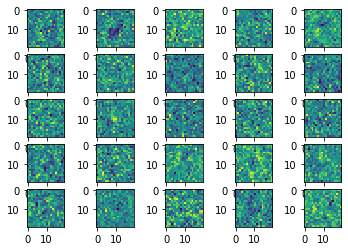

In [439]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()

### 15) Вычислите процент правильных классификаций на обучающей выборке.
### 17) Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

In [440]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0, backprop_strategy='analitic', random_state=42)
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=16, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.6628 	 test: 0.6412
Эпоха 1 	 train: 0.812 	 test: 0.7932
Эпоха 2 	 train: 0.8528 	 test: 0.8284
Эпоха 3 	 train: 0.8736 	 test: 0.8536
Эпоха 4 	 train: 0.8876 	 test: 0.8608
Эпоха 5 	 train: 0.8696 	 test: 0.8552
Эпоха 6 	 train: 0.9016 	 test: 0.8772
Эпоха 7 	 train: 0.9168 	 test: 0.8804
Эпоха 8 	 train: 0.9216 	 test: 0.8844
Эпоха 9 	 train: 0.9252 	 test: 0.89


0.89

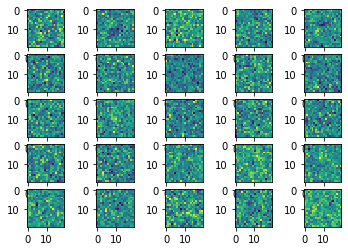

In [441]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn_l2.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()

In [442]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0001, backprop_strategy='analitic', random_state=42)
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=16, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.5636 	 test: 0.5496
Эпоха 1 	 train: 0.7852 	 test: 0.7756
Эпоха 2 	 train: 0.8092 	 test: 0.794
Эпоха 3 	 train: 0.8728 	 test: 0.8504
Эпоха 4 	 train: 0.8916 	 test: 0.8648
Эпоха 5 	 train: 0.9024 	 test: 0.8804
Эпоха 6 	 train: 0.9008 	 test: 0.8692
Эпоха 7 	 train: 0.9188 	 test: 0.8832
Эпоха 8 	 train: 0.9204 	 test: 0.8812
Эпоха 9 	 train: 0.9344 	 test: 0.8936


0.8936

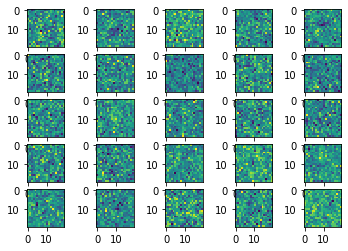

In [443]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn_l2.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()

In [444]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.001, backprop_strategy='analitic', random_state=42)
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=16, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.7016 	 test: 0.6824
Эпоха 1 	 train: 0.8012 	 test: 0.7736
Эпоха 2 	 train: 0.8596 	 test: 0.8252
Эпоха 3 	 train: 0.8588 	 test: 0.8372
Эпоха 4 	 train: 0.8956 	 test: 0.8772
Эпоха 5 	 train: 0.91 	 test: 0.8856
Эпоха 6 	 train: 0.9164 	 test: 0.89
Эпоха 7 	 train: 0.924 	 test: 0.8968
Эпоха 8 	 train: 0.9292 	 test: 0.9028
Эпоха 9 	 train: 0.936 	 test: 0.9072


0.9072

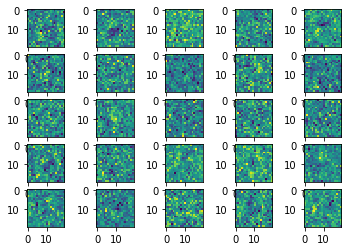

In [445]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn_l2.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()

In [450]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.005, backprop_strategy='analitic', random_state=42)
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=16, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.6624 	 test: 0.6636
Эпоха 1 	 train: 0.816 	 test: 0.806
Эпоха 2 	 train: 0.8564 	 test: 0.8536
Эпоха 3 	 train: 0.8648 	 test: 0.854
Эпоха 4 	 train: 0.8912 	 test: 0.888
Эпоха 5 	 train: 0.7968 	 test: 0.7844
Эпоха 6 	 train: 0.8752 	 test: 0.8468
Эпоха 7 	 train: 0.8648 	 test: 0.8504
Эпоха 8 	 train: 0.8604 	 test: 0.8512
Эпоха 9 	 train: 0.8868 	 test: 0.8832


0.8832

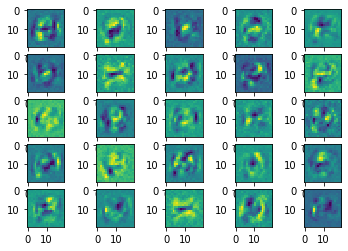

In [451]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn_l2.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()

In [446]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.01, backprop_strategy='analitic', random_state=42)
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=16, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.6272 	 test: 0.6252
Эпоха 1 	 train: 0.6312 	 test: 0.6424
Эпоха 2 	 train: 0.808 	 test: 0.8008
Эпоха 3 	 train: 0.848 	 test: 0.8432
Эпоха 4 	 train: 0.796 	 test: 0.7976
Эпоха 5 	 train: 0.802 	 test: 0.8124
Эпоха 6 	 train: 0.7752 	 test: 0.7872
Эпоха 7 	 train: 0.7432 	 test: 0.7264
Эпоха 8 	 train: 0.78 	 test: 0.7804
Эпоха 9 	 train: 0.8648 	 test: 0.8596


0.8596

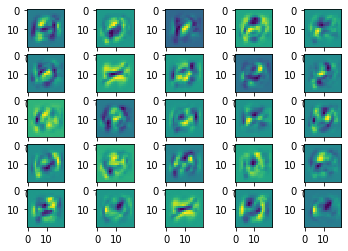

In [447]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn_l2.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()

In [448]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.05, backprop_strategy='analitic', random_state=42)
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=16, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.3132 	 test: 0.3152
Эпоха 1 	 train: 0.3352 	 test: 0.3492
Эпоха 2 	 train: 0.3708 	 test: 0.3832
Эпоха 3 	 train: 0.2876 	 test: 0.2928
Эпоха 4 	 train: 0.2048 	 test: 0.2036
Эпоха 5 	 train: 0.1936 	 test: 0.1968
Эпоха 6 	 train: 0.18 	 test: 0.184
Эпоха 7 	 train: 0.1088 	 test: 0.118
Эпоха 8 	 train: 0.166 	 test: 0.1688
Эпоха 9 	 train: 0.1372 	 test: 0.1428


0.1428

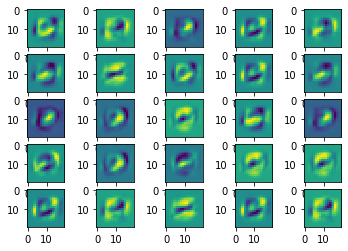

In [449]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn_l2.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()

In [434]:
final_train_data = list(zip(features, labels_onehot))

l2_best = 0.00075
nn_l2 = RegularizedNetwork([400, 25, 10], l2=l2_best, backprop_strategy='analitic', random_state=42)
nn_l2.SGD(final_train_data, eta=0.5, mini_batch_size=16, epochs=30, eta_reduce={7:0.2})

Эпоха 0 	 train: 0.8086
Эпоха 1 	 train: 0.8664
Эпоха 2 	 train: 0.8968
Эпоха 3 	 train: 0.9084
Эпоха 4 	 train: 0.926
Эпоха 5 	 train: 0.9314
Эпоха 6 	 train: 0.9222
new eta: 0.1
Эпоха 7 	 train: 0.9382
Эпоха 8 	 train: 0.9404
Эпоха 9 	 train: 0.9412
Эпоха 10 	 train: 0.9412
Эпоха 11 	 train: 0.943
Эпоха 12 	 train: 0.9438
Эпоха 13 	 train: 0.9444
Эпоха 14 	 train: 0.9436
Эпоха 15 	 train: 0.9448
Эпоха 16 	 train: 0.944
Эпоха 17 	 train: 0.946
Эпоха 18 	 train: 0.9464
Эпоха 19 	 train: 0.9446
Эпоха 20 	 train: 0.9458
Эпоха 21 	 train: 0.9488
Эпоха 22 	 train: 0.9474
Эпоха 23 	 train: 0.9486
Эпоха 24 	 train: 0.95
Эпоха 25 	 train: 0.9492
Эпоха 26 	 train: 0.9486
Эпоха 27 	 train: 0.95
Эпоха 28 	 train: 0.9488
Эпоха 29 	 train: 0.9508


In [435]:
predicted_indexes = nn_l2.predict_classes(features)
predicted_labels = le.inverse_transform(predicted_indexes)

(predicted_labels == labels).mean()

0.9508

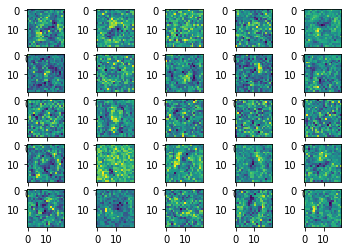

In [436]:
j = 0
f, axarr = plt.subplots(5, 5)
for i, wi in enumerate(nn_l2.weights[0]):
    if i != 0 and i % 5 == 0:
        j += 1
    axarr[j, i % 5].imshow(wi.reshape((20,20)), interpolation='none')
plt.show()